<a href="https://colab.research.google.com/github/srovins/kvasir_gi_images_classification/blob/main/extract_features_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
from google.colab import drive

In [2]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import InceptionV3

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
batch_size = 32
img_height = 244
img_width = 244

In [6]:
base_dir = '/content/drive/My Drive/Colab Notebooks/project_data/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
data_dir = train_dir

In [7]:
os.listdir(data_dir)

['polyps',
 'normal-z-line',
 'normal-pylorus',
 'dyed-resection-margins',
 'esophagitis',
 'ulcerative-colitis',
 'dyed-lifted-polyps',
 'normal-cecum']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 7200 files belonging to 8 classes.
Using 5760 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 7200 files belonging to 8 classes.
Using 1440 files for validation.


In [10]:
train_all = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 7200 files belonging to 8 classes.


# Augmentation and Normalization

In [11]:
def norm_data (ds):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))
  
  return norm_ds


In [12]:
def augument_data (ds, crop_size):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = norm_ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds


In [13]:
def augument_data1 (ds, crop_size):

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds



In [14]:
train_ds_aug = augument_data1 (train_ds, img_height-20)
train_ds_norm = norm_data (train_ds_aug)

In [15]:
val_ds_aug = augument_data1 (val_ds, img_height-20)
val_ds_norm = norm_data (val_ds_aug)

In [16]:
train_all_aug = augument_data1 (train_all, img_height-20)
train_all_norm = norm_data (train_all_aug)

In [17]:
# performance tuning
AUTOTUNE = tf.data.AUTOTUNE

train_ds_norm = train_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_norm = val_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
train_all_norm = train_all_norm.cache().prefetch(buffer_size=AUTOTUNE)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
train_all_aug = train_all_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
class_names = train_ds.class_names
print(class_names)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


**Examples of original images:**

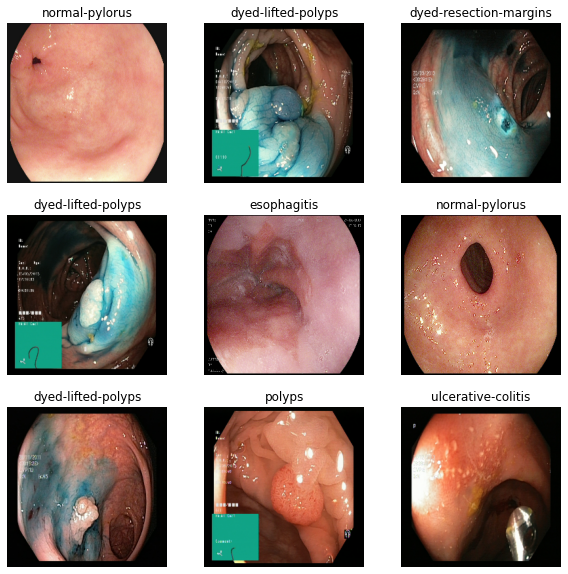

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

**Examples of augmented images:**

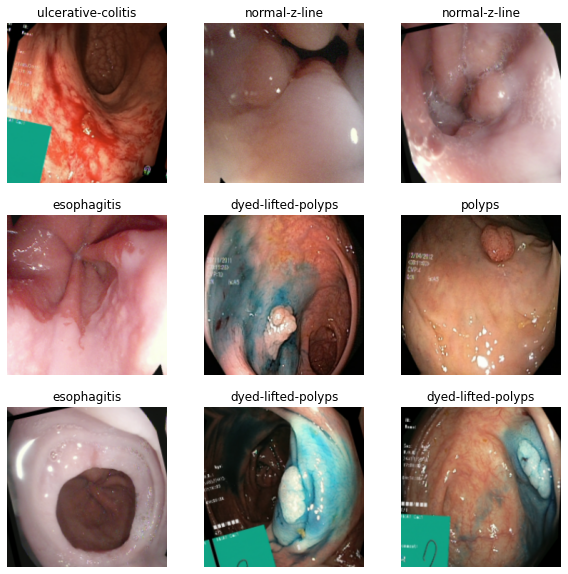

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Prepare Test dataset

In [35]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 800 files belonging to 8 classes.


In [36]:
test_ds_aug = augument_data1 (test_ds, img_height-20)
test_ds_norm = norm_data (test_ds_aug)

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds_norm = test_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
i = 0
y = np.zeros(shape=(800,8))
for inputs_batch, labels_batch in test_ds_norm:
  #print(inputs_batch.shape)
  y[i * batch_size : (i + 1) * batch_size] = labels_batch
  i += 1
  if i * batch_size >= 800:
      break

In [40]:
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

# CNN Model



In [20]:

from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

num_classes = 8

model2 = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  #layers.Dense(256, activation='relu'),
  #layers.Dropout(0.35),
  layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

In [21]:
opt1=optimizers.RMSprop(lr=2e-5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
opt2 = tf.keras.optimizers.SGD(lr=0.01, momentum=0.8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
opt3=optimizers.RMSprop(lr=0.001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
model2.compile(
  optimizer=opt1,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [30]:
hist_cnn_m2 = model2.fit(train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
180/180 [==============================] - 717s 4s/step - loss: 1.2060 - accuracy: 0.4998 - val_loss: 0.8057 - val_accuracy: 0.6431
Epoch 2/20
180/180 [==============================] - 27s 151ms/step - loss: 0.8584 - accuracy: 0.6134 - val_loss: 0.7045 - val_accuracy: 0.6854
Epoch 3/20
180/180 [==============================] - 27s 152ms/step - loss: 0.7779 - accuracy: 0.6519 - val_loss: 0.6535 - val_accuracy: 0.7174
Epoch 4/20
180/180 [==============================] - 27s 151ms/step - loss: 0.7168 - accuracy: 0.6898 - val_loss: 0.6148 - val_accuracy: 0.7299
Epoch 5/20
180/180 [==============================] - 27s 151ms/step - loss: 0.6857 - accuracy: 0.6918 - val_loss: 0.6006 - val_accuracy: 0.7292
Epoch 6/20
180/180 [==============================] - 27s 151ms/step - loss: 0.6540 - accuracy: 0.7137 - val_loss: 0.5738 - val_accuracy: 0.7368
Epoch 7/20
180/180 [==============================] - 27s 151ms/step - loss: 0.6279 - accuracy: 0.7236 - val_loss: 0.5751 - val_accu

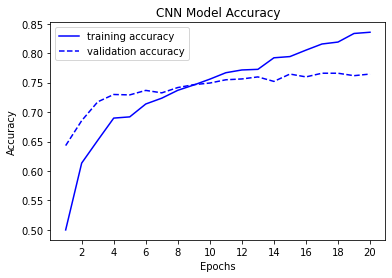

In [31]:
import matplotlib.pyplot as plt

acc = hist_cnn_m2.history['accuracy']
val_acc = hist_cnn_m2.history['val_accuracy']
loss = hist_cnn_m2.history['loss']
val_loss = hist_cnn_m2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.title('CNN Model Accuracy')
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'b--', label='validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(2, len(acc)+1, 2))
plt.legend()


plt.show()

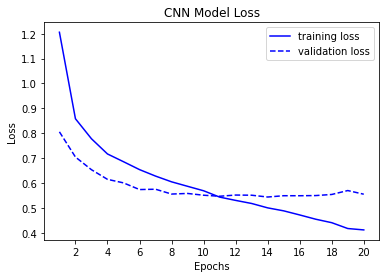

In [32]:


plt.title('CNN Model Loss')
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'b--', label='validation loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(2, len(loss)+1, 2))
plt.legend()


plt.show()

In [33]:
hist_cnn_m2 = model2.fit(val_ds_norm,
  epochs=10,
  validation_data = train_ds_norm
)

Epoch 1/10
45/45 [==============================] - 13s 298ms/step - loss: 0.6123 - accuracy: 0.7340 - val_loss: 0.3820 - val_accuracy: 0.8495
Epoch 2/10
45/45 [==============================] - 13s 298ms/step - loss: 0.5659 - accuracy: 0.7618 - val_loss: 0.3733 - val_accuracy: 0.8524
Epoch 3/10
45/45 [==============================] - 13s 298ms/step - loss: 0.5398 - accuracy: 0.7708 - val_loss: 0.4038 - val_accuracy: 0.8316
Epoch 4/10
45/45 [==============================] - 13s 298ms/step - loss: 0.5101 - accuracy: 0.7833 - val_loss: 0.4012 - val_accuracy: 0.8344
Epoch 5/10
45/45 [==============================] - 13s 298ms/step - loss: 0.4868 - accuracy: 0.7896 - val_loss: 0.3847 - val_accuracy: 0.8401
Epoch 6/10
45/45 [==============================] - 13s 297ms/step - loss: 0.4676 - accuracy: 0.8118 - val_loss: 0.3754 - val_accuracy: 0.8486
Epoch 7/10
45/45 [==============================] - 13s 297ms/step - loss: 0.4469 - accuracy: 0.8160 - val_loss: 0.3848 - val_accuracy: 0.8378

In [41]:
model2.evaluate(test_ds_norm)

25/25 [==============================] - 1s 41ms/step - loss: 0.5956 - accuracy: 0.7450


[0.5956164002418518, 0.7450000047683716]

In [42]:
test_pred = model2.predict(test_ds_norm)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y, axis=1), np.argmax(test_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.69      0.46      0.55       100
           1       0.61      0.82      0.70       100
           2       0.71      0.71      0.71       100
           3       0.88      0.83      0.86       100
           4       0.93      0.94      0.94       100
           5       0.69      0.73      0.71       100
           6       0.72      0.75      0.74       100
           7       0.77      0.72      0.75       100

    accuracy                           0.74       800
   macro avg       0.75      0.74      0.74       800
weighted avg       0.75      0.74      0.74       800



In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(test_pred, axis=1))

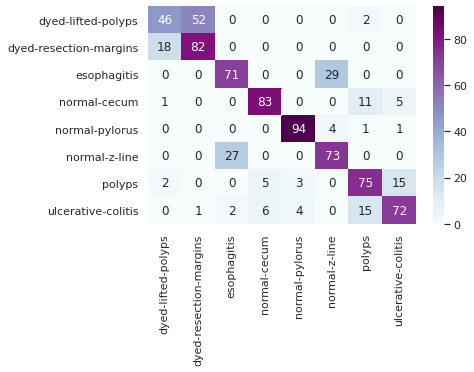

In [47]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

# Hyperparameters tuning

**Caution:** Since tuning code re-trains the model with a number of different hyperparameters, it will take a long time to complete all tests.

In [51]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [52]:
def get_model(num_classes = 8, drop_out=0.4, reg=None, n_densenodes=256):

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=reg))
  model.add(layers.Conv2D(64, 3, activation='relu', padding='same',
                kernel_regularizer=reg))

  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dropout(drop_out))

  model.add(layers.Dense(n_densenodes, activation='relu', kernel_regularizer=reg))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=reg))
  
  return model

In [53]:
def optimizer_search(iters=10):
  
  opt1 = optimizers.RMSprop(lr=2e-5)
  opt2 = optimizers.RMSprop(lr=2e-4)
  opt3 = optimizers.SGD(lr=0.001, momentum=0.8)
  opt4 = optimizers.SGD(lr=0.001, momentum=0.9)
  opt5 = optimizers.SGD(lr=0.01, momentum=0.8)
  opt6 = optimizers.SGD(lr=0.01, momentum=0.9)
  opt7 = optimizers.SGD(lr=0.0001, momentum=0.8)
  opt8 = optimizers.SGD(lr=0.0001, momentum=0.9)
  opt9 = optimizers.Adam()

  opt_list = [opt1, opt2, opt3, opt4, opt5, opt6, opt7, opt8, opt9]
  opt_name = ['RMSprop(lr=2e-5)', 
              'RMSprop(lr=2e-4)', 
              'SGD(lr=0.001, momentum=0.8)',
              'SGD(lr=0.001, momentum=0.9)',
              'SGD(lr=0.01, momentum=0.8)',
              'SGD(lr=0.01, momentum=0.9)',
              'SGD(lr=0.0001, momentum=0.8)',
              'SGD(lr=0.0001, momentum=0.9)',
              'adam']
  opt_hist=[]

  # regularizers.l2(1e-4)

  # 1. pick optimizer
  
  
  for i, opt in enumerate(opt_list):
    print(opt_name[i])
    model = get_model()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    opt_hist.append(h)
    print("")
  
  return opt_hist, opt_name



  """
  for m in momentums:
    model = get_model()
    opt = tf.keras.optimizers.SGD(lr=best_lr, momentum = m)
    model.compile(optimizer=opt,
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(normtrain_ds ,epochs=iters)
    score = model.evaluate(normval_ds, verbose=0)
    if score[1] > best_acc:
      best_acc = score[1]
      best_mom = m

  print('best lr: ', best_lr)
  print('best momentum: ', best_mom)"""

  


In [54]:
opt_hist = optimizer_search()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


RMSprop(lr=2e-5)
Epoch 1/15
180/180 [==============================] - 29s 152ms/step - loss: 1.1328 - accuracy: 0.5148 - val_loss: 0.7912 - val_accuracy: 0.6410
Epoch 2/15
180/180 [==============================] - 27s 151ms/step - loss: 0.8453 - accuracy: 0.6222 - val_loss: 0.7250 - val_accuracy: 0.6722
Epoch 3/15
180/180 [==============================] - 27s 151ms/step - loss: 0.7796 - accuracy: 0.6481 - val_loss: 0.6948 - val_accuracy: 0.6812
Epoch 4/15
180/180 [==============================] - 27s 151ms/step - loss: 0.7347 - accuracy: 0.6729 - val_loss: 0.6464 - val_accuracy: 0.7063
Epoch 5/15
180/180 [==============================] - 27s 151ms/step - loss: 0.7045 - accuracy: 0.6892 - val_loss: 0.6322 - val_accuracy: 0.7146
Epoch 6/15
180/180 [==============================] - 27s 151ms/step - loss: 0.6766 - accuracy: 0.6964 - val_loss: 0.6206 - val_accuracy: 0.7132
Epoch 7/15
180/180 [==============================] - 27s 151ms/step - loss: 0.6456 - accuracy: 0.7177 - val_loss

In [55]:

def reguralizer_search(iters=10):
  
  opt3 = optimizers.SGD(lr=0.001, momentum=0.8)
  reg1 = regularizers.l2(1e-4)
  reg2 = regularizers.l1(1e-5)
  reg3 = regularizers.l2(1e-5)
  reg4 = regularizers.l2(1e-3)

  reg_list = [reg1, reg2, reg3, reg4]
  reg_name = ['regularizers.l2(1e-4)', 
              'regularizers.l1(1e-5)', 
              'regularizers.l2(1e-5)',
              'regularizers.l2(1e-3)']
  reg_hist=[]

  # regularizers.l2(1e-4)

  # 2. pick regularizer
  for i, r in enumerate(reg_list):
    print(reg_name[i])
    model = get_model(reg=r)
    model.compile(optimizer=opt3, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    reg_hist.append(h)
    print("")
  
  return reg_hist, reg_name



In [56]:
reg_hist = reguralizer_search()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


regularizers.l2(1e-4)
Epoch 1/15
180/180 [==============================] - 27s 146ms/step - loss: 1.8584 - accuracy: 0.2507 - val_loss: 1.0739 - val_accuracy: 0.5507
Epoch 2/15
180/180 [==============================] - 26s 145ms/step - loss: 1.0102 - accuracy: 0.5594 - val_loss: 0.7811 - val_accuracy: 0.6597
Epoch 3/15
180/180 [==============================] - 26s 145ms/step - loss: 0.8650 - accuracy: 0.6151 - val_loss: 0.7448 - val_accuracy: 0.6618
Epoch 4/15
180/180 [==============================] - 26s 145ms/step - loss: 0.8053 - accuracy: 0.6413 - val_loss: 0.7184 - val_accuracy: 0.6757
Epoch 5/15
180/180 [==============================] - 26s 145ms/step - loss: 0.7542 - accuracy: 0.6632 - val_loss: 0.6887 - val_accuracy: 0.6868
Epoch 6/15
180/180 [==============================] - 26s 145ms/step - loss: 0.7425 - accuracy: 0.6708 - val_loss: 0.6856 - val_accuracy: 0.6785
Epoch 7/15
180/180 [==============================] - 26s 145ms/step - loss: 0.7125 - accuracy: 0.6771 - val

# Learn and extract image features

## VGG16

In [106]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [ ]:


# load model without classifier layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.4)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.4)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
opt1 = optimizers.SGD(lr=0.01, momentum=0.8)
opt2 = optimizers.RMSprop(lr=2e-5)
opt3="adam"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.compile(
  optimizer=opt2,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
history1 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
180/180 [==============================] - 1330s 7s/step - loss: 1.6525 - accuracy: 0.3815 - val_loss: 0.6691 - val_accuracy: 0.7222
Epoch 2/20
180/180 [==============================] - 41s 225ms/step - loss: 0.6972 - accuracy: 0.7424 - val_loss: 0.4484 - val_accuracy: 0.8417
Epoch 3/20
180/180 [==============================] - 40s 224ms/step - loss: 0.4868 - accuracy: 0.8230 - val_loss: 0.4088 - val_accuracy: 0.8528
Epoch 4/20
180/180 [==============================] - 40s 224ms/step - loss: 0.3972 - accuracy: 0.8651 - val_loss: 0.3522 - val_accuracy: 0.8799
Epoch 5/20
180/180 [==============================] - 40s 225ms/step - loss: 0.3146 - accuracy: 0.8975 - val_loss: 0.3896 - val_accuracy: 0.8646
Epoch 6/20
180/180 [==============================] - 40s 225ms/step - loss: 0.2727 - accuracy: 0.9125 - val_loss: 0.3797 - val_accuracy: 0.8743
Epoch 7/20
180/180 [==============================] - 40s 224ms/step - loss: 0.2244 - accuracy: 0.9365 - val_loss: 0.4052 - val_acc

In [ ]:
model.fit(train_all_norm,
          epochs=14)

Epoch 1/14
225/225 [==============================] - 102s 446ms/step - loss: 0.2176 - accuracy: 0.9369
Epoch 2/14
225/225 [==============================] - 47s 210ms/step - loss: 0.1569 - accuracy: 0.9581
Epoch 3/14
225/225 [==============================] - 47s 208ms/step - loss: 0.1353 - accuracy: 0.9658
Epoch 4/14
225/225 [==============================] - 47s 208ms/step - loss: 0.1101 - accuracy: 0.9729
Epoch 5/14
225/225 [==============================] - 47s 208ms/step - loss: 0.0880 - accuracy: 0.9794
Epoch 6/14
225/225 [==============================] - 47s 208ms/step - loss: 0.0838 - accuracy: 0.9825
Epoch 7/14
225/225 [==============================] - 47s 208ms/step - loss: 0.0818 - accuracy: 0.9842
Epoch 8/14
225/225 [==============================] - 47s 208ms/step - loss: 0.0768 - accuracy: 0.9808
Epoch 9/14
225/225 [==============================] - 47s 208ms/step - loss: 0.0735 - accuracy: 0.9854
Epoch 10/14
225/225 [==============================] - 47s 208ms/step - 

In [ ]:
model.save("vgg16.h5")

In [121]:
from keras.models import load_model

In [134]:
model_vgg = load_model('vgg16.h5')

In [144]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [145]:
vgg_features_model = Model (model_vgg.layers[0].input,  model_vgg.layers[21].output)

In [146]:
vgg_features_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [135]:
model_vgg.evaluate(test_ds_norm)

25/25 [==============================] - 2s 40ms/step - loss: 0.4194 - accuracy: 0.9087


[0.4193662703037262, 0.9087499976158142]

In [136]:
predict_test = model_vgg.predict(test_ds_norm)

In [137]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y, axis=1), np.argmax(predict_test, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       100
           1       0.94      0.95      0.95       100
           2       0.78      0.74      0.76       100
           3       0.97      0.99      0.98       100
           4       0.99      0.99      0.99       100
           5       0.75      0.82      0.78       100
           6       0.98      0.91      0.94       100
           7       0.93      0.95      0.94       100

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



In [138]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average='weighted')

0.9104881236873251

In [139]:
np.average(recall_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.90875

In [140]:
np.average(f1_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.9091259730758589

In [142]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))

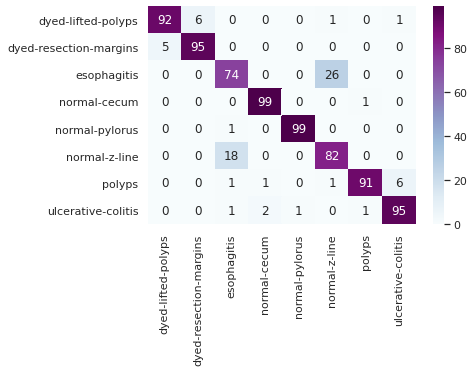

In [143]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

## DenseNet-169

In [107]:
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers

# load model without classifier layers
model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.5)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.5)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)

# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [108]:
model.compile(
  optimizer=optimizers.RMSprop(lr=2e-5),
  loss="categorical_crossentropy",
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [109]:
history3 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
180/180 [==============================] - 1395s 7s/step - loss: 2.1333 - accuracy: 0.3772 - val_loss: 0.6010 - val_accuracy: 0.7951
Epoch 2/20
180/180 [==============================] - 34s 187ms/step - loss: 0.5994 - accuracy: 0.7923 - val_loss: 0.3388 - val_accuracy: 0.8806
Epoch 3/20
180/180 [==============================] - 33s 186ms/step - loss: 0.3687 - accuracy: 0.8841 - val_loss: 0.3236 - val_accuracy: 0.8882
Epoch 4/20
180/180 [==============================] - 33s 186ms/step - loss: 0.2625 - accuracy: 0.9177 - val_loss: 0.3332 - val_accuracy: 0.9028
Epoch 5/20
180/180 [==============================] - 34s 186ms/step - loss: 0.1739 - accuracy: 0.9526 - val_loss: 0.3721 - val_accuracy: 0.9049
Epoch 6/20
180/180 [==============================] - 33s 186ms/step - loss: 0.1204 - accuracy: 0.9684 - val_loss: 0.3871 - val_accuracy: 0.9028
Epoch 7/20
180/180 [==============================] - 34s 186ms/step - loss: 0.0965 - accuracy: 0.9789 - val_loss: 0.4297 - val_acc

In [110]:
model.fit(train_all_norm,
          epochs=17)

Epoch 1/17
225/225 [==============================] - 76s 334ms/step - loss: 0.3082 - accuracy: 0.9417
Epoch 2/17
225/225 [==============================] - 39s 175ms/step - loss: 0.0974 - accuracy: 0.9767
Epoch 3/17
225/225 [==============================] - 39s 175ms/step - loss: 0.0525 - accuracy: 0.9890
Epoch 4/17
225/225 [==============================] - 39s 175ms/step - loss: 0.0379 - accuracy: 0.9912
Epoch 5/17
225/225 [==============================] - 39s 174ms/step - loss: 0.0329 - accuracy: 0.9951
Epoch 6/17
225/225 [==============================] - 39s 175ms/step - loss: 0.0346 - accuracy: 0.9939
Epoch 7/17
225/225 [==============================] - 39s 174ms/step - loss: 0.0285 - accuracy: 0.9958
Epoch 8/17
225/225 [==============================] - 40s 177ms/step - loss: 0.0245 - accuracy: 0.9969
Epoch 9/17
225/225 [==============================] - 40s 178ms/step - loss: 0.0260 - accuracy: 0.9961
Epoch 10/17
225/225 [==============================] - 40s 176ms/step - l

In [156]:
model.evaluate(test_ds_norm)

25/25 [==============================] - 1s 47ms/step - loss: 0.7927 - accuracy: 0.9262


[0.7926753163337708, 0.9262499809265137]

In [157]:
predict_test = model.predict(test_ds_norm)

In [158]:
predict_test.shape

(800, 8)

In [111]:
model.save("densenet.h5")

In [160]:
from keras.models import load_model
model_dn = load_model('densenet.h5')

In [161]:
model_dn.summary ()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [163]:
dn_features_model = Model (model_dn.layers[0].input,  model_dn.layers[597].output)

In [164]:
dn_features_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [184]:
pred_test = model.predict(test_ds_norm)

In [187]:
from sklearn.metrics import precision_score, recall_score, f1_score
np.average(precision_score(np.argmax(y, axis=1), np.argmax(pred_test, axis=1), average='weighted'))

0.9264174673316097

In [188]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))

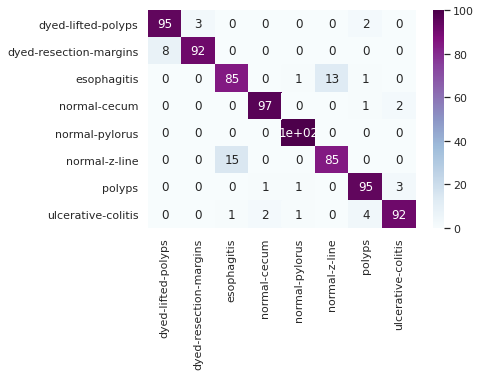

In [189]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

# Save features to pickle file for future use

In [ ]:
import pandas as pd

In [199]:
vgg_features = vgg_features_model.predict(train_ds_norm)
vgg_features_val = vgg_features_model.predict(val_ds_norm)
vgg_features_test = vgg_features_model.predict(test_ds_norm)

In [200]:
df_features = pd.DataFrame(vgg_features)
df_features.to_pickle("vgg_features.pkl")
df_features = pd.DataFrame(vgg_features_val)
df_features.to_pickle("vgg_features_val.pkl")
df_features = pd.DataFrame(vgg_features_test)
df_features.to_pickle("vgg_features_test.pkl")

In [204]:
dn_features = dn_features_model.predict(train_ds_norm)
dn_features_val = dn_features_model.predict(val_ds_norm)
dn_features_test = dn_features_model.predict(test_ds_norm)

In [205]:
y_train = np.concatenate([y for x, y in train_ds_norm], axis=0)
y_val = np.concatenate([y for x, y in val_ds_norm], axis=0)
y_test = np.concatenate([y for x, y in test_ds_norm], axis=0)

In [206]:
df_features = pd.DataFrame(dn_features)
df_features["label"] = np.argmax(y_train, axis=1)
df_features.to_pickle("dn_features.pkl")

df_features = pd.DataFrame(dn_features_val)
df_features["label"] = np.argmax(y_val, axis=1)
df_features.to_pickle("dn_features_val.pkl")

df_features = pd.DataFrame(dn_features_test)
df_features["label"] = np.argmax(y_test, axis=1)
df_features.to_pickle("dn_features_test.pkl")